Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

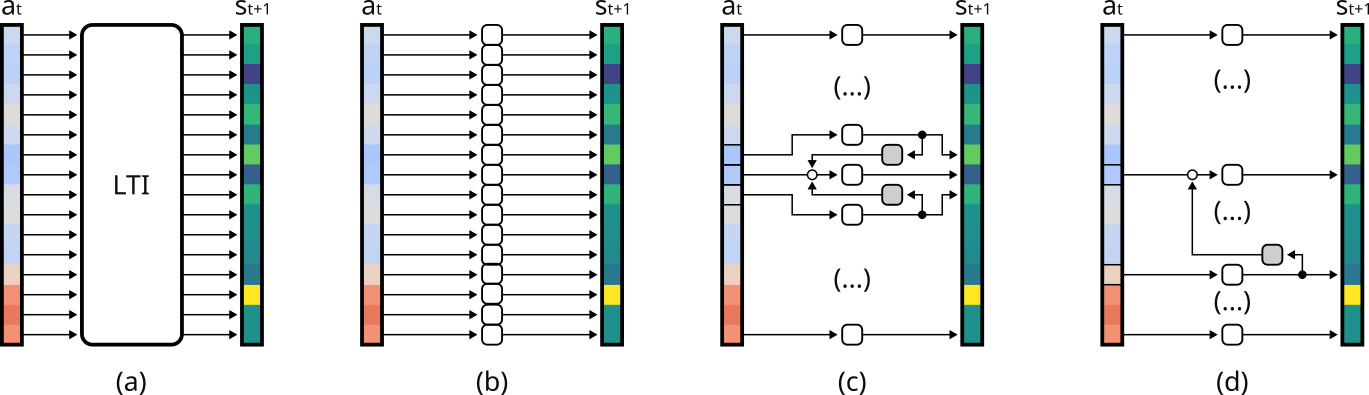

In [ ]:
!pip3 install control==0.9.4 --force-reinstall --quiet
#!pip install diffusers --quiet
#!pip install datasets --quiet

In [ ]:
import numpy as np, pylab as plt
import control as ct, cv2

from scipy.ndimage import gaussian_filter
import matplotlib.animation as animation

from tqdm import tqdm
import os

from matplotlib import rc
rc('animation', html='jshtml')

# SPDL class

In [ ]:
class SPDL_DB():
    def __init__(self, n=32, n_step=100, t=10):
        self.n = n
        self.n_step = n_step
        self.t = t
        # init
        self.N = n*n
        self.T = np.linspace(0, t, n_step)
        self.mode = None
        self.sys = None
        # spatial connection
        self.isconnected = False
        self.Qd = self.diffusion_map()
        self.isdiffuse = False
        self.smooth = True
        self.scaling = None

    def diffusion_map(self):
        # index link
        idx = np.arange(self.N).reshape((self.n,self.n))
        lleft = [str(l) + '.y' for l in np.roll(idx,1,axis=1).flatten()]
        lright = [str(l) + '.y' for l in np.roll(idx,-1,axis=1).flatten()]
        lup = [str(l) + '.y' for l in np.roll(idx,1,axis=0).flatten()]
        ldown = [str(l) + '.y' for l in np.roll(idx,-1,axis=0).flatten()]
        idx = idx.flatten()
        # Local Diffusion
        Q = [[str(i+self.N)+'.u']+[lleft[i]]+[lright[i]]+[lup[i]]+[ldown[i]] for i in idx]
        Q += [[str(i)+'.u']+[str(i+self.N)+'.y'] for i in idx]
        return tuple(map(tuple, tuple(Q)))

    def ss_scaling(self,) :
      pass # TO DO LOOP CLONE

    def reset(self, mode=None, c=None, d=None) :
        self.mode = mode if mode != None else np.random.randint(3)
        # one complex system
        if self.mode == 0 :
          self.isconnected = False
          self.isdiffuse = False
          self.sys = ct.rss(states=4, outputs=self.N, inputs=self.N)
        # multiple simple system
        else :
          ss = []
          # connection
          self.isconnected = c if c != None else np.random.randint(2, dtype=bool)
          if self.isconnected :
            for i in range(self.N) :
              G = ct.TransferFunction([+1./(2*self.N)],[1]) # Gain loop
              G = ct.LinearIOSystem(G, name=str(self.N+i), inputs='u', outputs='y')
              ss += [G]
          # random system
          if self.mode == 1 :
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.rss(1), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # a/s+1
          else :
            a = 2*np.random.random((self.n,self.n)) - 1
            G = cv2.blur(a,(self.n,self.n))
            g = G.flatten() #g_2D = G.reshape(G.shape)
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.TransferFunction(g[i],[1,1]), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # interconnect (disjoint or not)
          in_ , out_ = [f'u[{i}]'  for i in range(self.N)], [f'y[{i}]'  for i in range(self.N)]
          inplist, outlist = [[f'{i}.u'] for i in range(self.N)], [[f'{i}.y'] for i in range(self.N)]
          if self.isconnected :
            self.isdiffuse = d if d != None else np.random.randint(2, dtype=bool)
            if self.isdiffuse : Q = self.Qd
            else :
              # randomized
              idx = np.arange(self.N)
              R = np.random.choice(idx, size=self.N, replace=False)
              # construct connection without Algebraic loop ([idx!=R])
              Q = [[str(i+self.N)+'.u']+[str(R[i]) + '.y'] for i in idx[idx!=R]]
              Q += [[str(i)+'.u']+[str(i+self.N)+'.y'] for i in idx[idx!=R]]
              Q = tuple(map(tuple, tuple(Q)))
          else :
            self.isdiffuse = False
            Q = None
          self.Q = Q
          self.sys = ct.InterconnectedSystem(ss, connections=Q, inplist=inplist, inputs=in_, outlist=outlist, outputs=out_)

    def step(self, smooth=None) :
        # initial state
        s_scaling = np.power(2, np.random.randint(0,np.log2(self.n)))
        X0 = 2*np.random.random((self.n//s_scaling, self.n//s_scaling)) - 1
        X0 = np.repeat(np.repeat(X0, s_scaling, axis=1), s_scaling, axis=0)
        X0 = X0.flatten()[:,None]
        ## random input for each time
        in_scaling = np.power(2, np.random.randint(0,np.log2(self.n)))
        U_3D = 2*np.random.random((self.n//in_scaling, self.n//in_scaling, self.n_step)) - 1
        U_3D = np.repeat(np.repeat(U_3D, in_scaling, axis=1), in_scaling, axis=0)
        # save scaling
        self.scaling = (s_scaling,in_scaling)
        # smooth input in time (or not)
        self.smooth = smooth if smooth != None else np.random.randint(2, dtype=bool)
        d = float(self.isdiffuse)
        U_3D = gaussian_filter(U_3D, (d, d, 1.)) if self.smooth else U_3D
        U = U_3D.reshape((self.N,self.n_step))
        ## simulate
        if self.mode == 0 :
          T, yout, self.X = ct.forced_response(self.sys, T=self.T, U=U, X0=X0[:self.sys.nstates], return_x=True)
        else :
          T, yout, self.X = ct.input_output_response(self.sys, T=self.T, U=U, X0=X0, return_x=True)
        return U.T, yout.T

    def animate(self, S, RGB=False):
      fig, ax = plt.subplots()
      plt.axis('off')
      ims, i = [], 0
      for s in S :
        s_2D = s.reshape((self.n,self.n,3)) if RGB else s.reshape((self.n,self.n))
        blur = cv2.blur(s_2D,(3,3))
        im = ax.imshow(s_2D, animated=True)
        if i == 0 : ax.imshow(blur); i+=1
        ims.append([im])
      anim = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=True)
      return anim

In [ ]:
"""
# some unit tests
n, n_step = 32, 10
in_scaling = np.power(2, np.random.randint(0,np.log2(n)))
U_3D = 2*np.random.random((n//in_scaling, n//in_scaling, n_step)) - 1
U_3D = np.repeat(np.repeat(U_3D, in_scaling, axis=1), in_scaling, axis=0)
U = U_3D.reshape((n*n,n_step))
# show
plt.imshow(U_3D[:,:,0]);plt.show()
U0 = U[:,0].reshape((n,n))
plt.imshow(U0);plt.show()
"""

'\n# some unit tests\nn, n_step = 32, 10\nin_scaling = np.power(2, np.random.randint(0,np.log2(n)))\nU_3D = 2*np.random.random((n//in_scaling, n//in_scaling, n_step)) - 1\nU_3D = np.repeat(np.repeat(U_3D, in_scaling, axis=1), in_scaling, axis=0)\nU = U_3D.reshape((n*n,n_step))\n# show\nplt.imshow(U_3D[:,:,0]);plt.show()\nU0 = U[:,0].reshape((n,n))\nplt.imshow(U0);plt.show()\n'

# SPDL Database Contruct

## step test

In [ ]:
ct.__version__

'0.9.4'

In [ ]:
spdl = SPDL_DB(n_step=10)#8) --> 32 min for Diffusion
spdl.reset(mode=1, c=True, d=False)
spdl.mode

1

(1024, 1)
(2, 8)


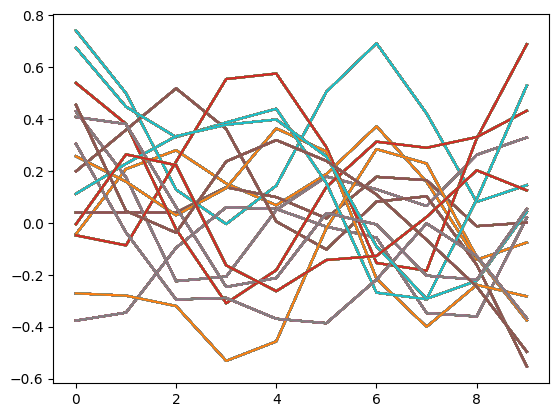

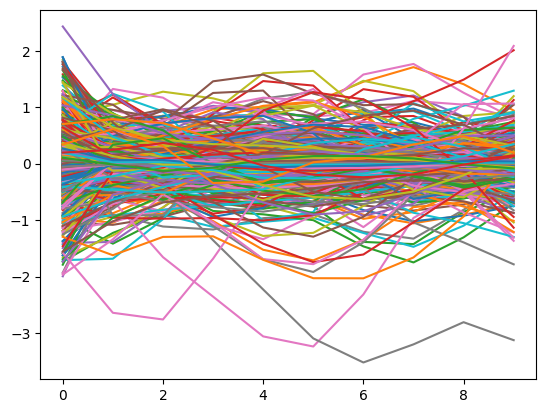

In [ ]:
action, state = spdl.step(smooth=True)
print(spdl.scaling)
plt.plot(action); plt.show()
plt.plot(state); plt.show()

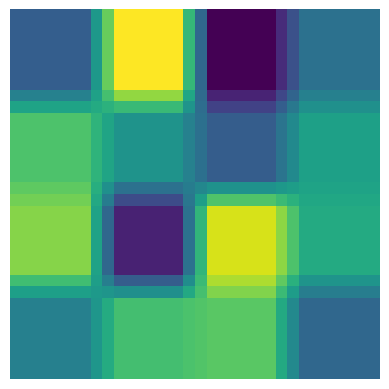

In [ ]:
anim_a = spdl.animate(action)

In [ ]:
anim_a

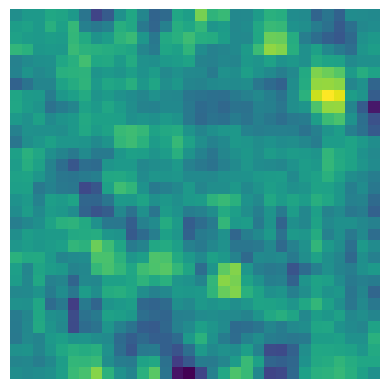

In [ ]:
anim_s = spdl.animate(state)

In [ ]:
anim_s

## Construction d'une image pour diffusion

In [ ]:
n, N,T = spdl.n, spdl.N, spdl.n_step

In [ ]:
a = action.reshape((T,n,n,1))
s = state.reshape((T,n,n,1))

In [ ]:
a_ = (((a - a.min()) / (a.max() - a.min())) * 255).astype(np.uint8)
s_ = (((s - s.min()) / (s.max() - s.min())) * 255).astype(np.uint8)

In [ ]:
v = np.concatenate((a_[1:], s_[:-1], s_[1:]), axis = 3) # bof (mettre une image 5D pour l'entrainement des UNet)

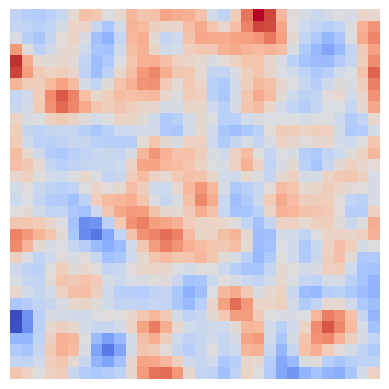

In [ ]:
plt.imshow(a[6], cmap='coolwarm'); plt.axis('off'); plt.show()

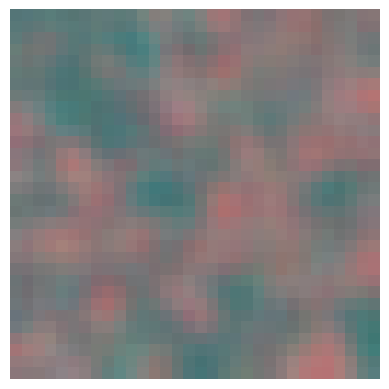

In [ ]:
anim_rgb = spdl.animate(v, RGB=True) # bof

In [ ]:
#anim_rgb

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"
"""

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\ndirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"\n'

In [ ]:
"""
plt.imshow(s[0], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t-1).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(a[5], cmap='coolwarm'); plt.axis('off'); plt.savefig(dirpath+"example_a(t-1).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(s[6], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(a[6], cmap='coolwarm'); plt.axis('off'); plt.savefig(dirpath+"example_a(t).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(s[-1], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t+1).png", bbox_inches='tight', pad_inches=0); plt.show()
"""

'\nplt.imshow(s[0], cmap=\'viridis\'); plt.axis(\'off\'); plt.savefig(dirpath+"example_s(t-1).png", bbox_inches=\'tight\', pad_inches=0); plt.show()\nplt.imshow(a[5], cmap=\'coolwarm\'); plt.axis(\'off\'); plt.savefig(dirpath+"example_a(t-1).png", bbox_inches=\'tight\', pad_inches=0); plt.show()\nplt.imshow(s[6], cmap=\'viridis\'); plt.axis(\'off\'); plt.savefig(dirpath+"example_s(t).png", bbox_inches=\'tight\', pad_inches=0); plt.show()\nplt.imshow(a[6], cmap=\'coolwarm\'); plt.axis(\'off\'); plt.savefig(dirpath+"example_a(t).png", bbox_inches=\'tight\', pad_inches=0); plt.show()\nplt.imshow(s[-1], cmap=\'viridis\'); plt.axis(\'off\'); plt.savefig(dirpath+"example_s(t+1).png", bbox_inches=\'tight\', pad_inches=0); plt.show()\n'

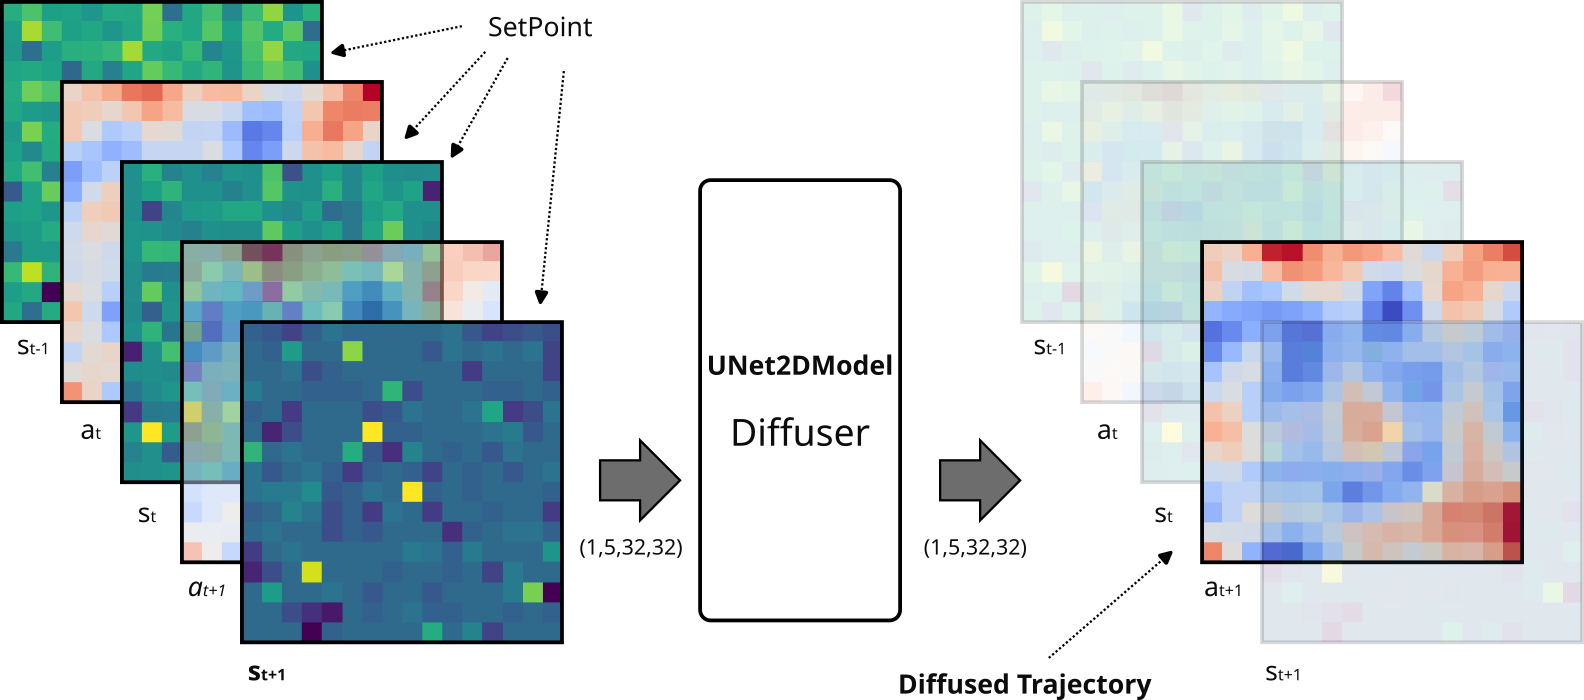

## Test UnetDiffuser

https://huggingface.co/docs/diffusers/tutorials/basic_training

https://github.com/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

Pour la derniere couche, on a un Squeeze https://arxiv.org/pdf/1709.01507.pdf

Test a noisy prediction

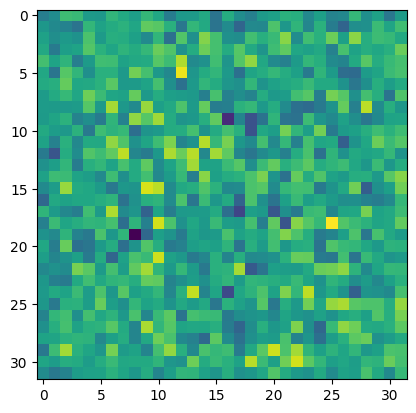

In [ ]:
from diffusers import UNet2DModel
import torch

n_channel = 5 #3
size = 32 #128 --> 32 minimum (block convolution)

random = torch.rand((1,n_channel,size,size), dtype=torch.float)

model = UNet2DModel(
    sample_size=size,  # the target image resolution
    in_channels= n_channel,
    out_channels= n_channel,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(size, size, 2*size, 2*size, 4*size, 4*size),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

noise_pred = model(random, torch.LongTensor([2]), return_dict=False)[0]
plt.imshow(noise_pred.detach().numpy()[0,0]); plt.show()

In [ ]:
#model

## Create dataset

https://huggingface.co/docs/diffusers/training/create_dataset

https://huggingface.co/docs/datasets/create_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import Dataset, load_dataset

import pandas as pd

### testing

https://huggingface.co/docs/datasets/v2.18.0/loading

https://huggingface.co/docs/datasets/v1.2.1/loading_datasets.html

In [ ]:
A = action.reshape((T,1,n,n))
S = state.reshape((T,1,n,n))

In [ ]:
minimal_sample = np.concatenate((S, A), axis = 1)
np.save(dirpath + "examples/minimal_sample_test", minimal_sample) #1.6Mo
np.savez_compressed(dirpath + "examples/minimal_sample_test", minimal_sample) #1.5 (same size if sample compressed)

In [ ]:
sample = np.concatenate((S[:-2], A[1:-1], S[1:-1], A[2:], S[2:]), axis = 1)
sample.shape

(98, 5, 32, 32)

In [ ]:
np.save(dirpath + "examples/sample_test", sample) #3.8Mo
np.savez_compressed(dirpath + "examples/sample_test", sample) #1.5 (same size if sample compressed --> operation concerved ?)

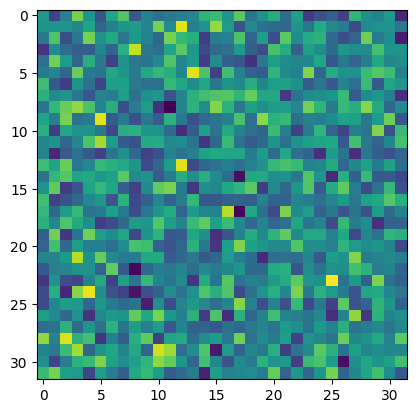

In [ ]:
plt.imshow(sample[0,0]); plt.show()

In [ ]:
A_ = (((A - A.min()) / (A.max() - A.min())) * 255).astype(np.uint8)
S_ = (((S - S.min()) / (S.max() - S.min())) * 255).astype(np.uint8)

In [ ]:
sample_uint8 = np.concatenate((S_[:-2], A_[1:-1], S_[1:-1], A_[2:], S_[2:]), axis = 1)

In [ ]:
np.save(dirpath + "examples/sample_test_uint8", sample_uint8) # 490Ko --> 8 fois moins d'espace
np.savez(dirpath + "examples/sample_test_uint8", sample_uint8) # 490Ko --> 8 fois moins d'espace

In [ ]:
a = np.load(dirpath + "examples/sample_test_uint8.npz")
b = np.load(dirpath + "examples/sample_test_uint8.npy")

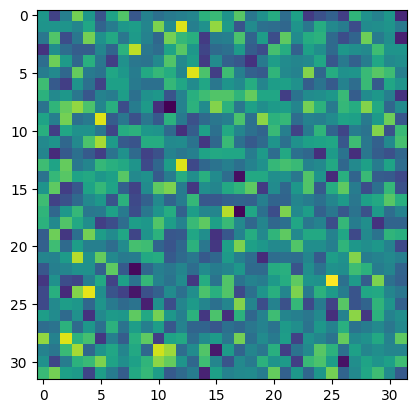

In [ ]:
plt.imshow(sample_uint8[0,0]); plt.show()

In [ ]:
a,b = action.shape
p = np.mgrid[0:a,:b].reshape((2,a*b))
p.shape

(2, 102400)

In [ ]:
array = np.concatenate((p,action.reshape((1,a*b)), state.reshape((1,a*b)))).T
array.shape

(102400, 4)

In [ ]:
test_df = pd.DataFrame(array, columns=["time", "index", "action", "state"])
test_df.head()

,time,index,action,state
0,0.0,0.0,-0.022813,0.952608
1,0.0,1.0,-0.152134,-4.276886
2,0.0,2.0,-0.272568,-0.632956
3,0.0,3.0,-0.252161,4.973319
4,0.0,4.0,-0.196828,0.781578


In [ ]:
test_df.to_csv(dirpath + "examples/sample_dftest.csv", index=False) # 5Mo
test_df.to_csv(dirpath + "examples/sample_dftest.zip", index=False, compression='gzip') # 2.1Mo

In [ ]:
test_df_reduce = test_df.round(2)
test_df_reduce.head()

,time,index,action,state
0,0.0,0.0,-0.02,0.95
1,0.0,1.0,-0.15,-4.28
2,0.0,2.0,-0.27,-0.63
3,0.0,3.0,-0.25,4.97
4,0.0,4.0,-0.20,0.78


In [ ]:
test_df_reduce.to_csv(dirpath + "examples/sample_dftest_reduce.csv", index=False) # 2.1Mo
test_df_reduce.to_csv(dirpath + "examples/sample_dftest_reduce.zip", index=False, compression='gzip') # 526Ko

In [ ]:
#dataset = Dataset.from_pandas(test_df)

Avantage : Plus simple, manipulable facilement sur les outils HuggingFace
Désavantage : Volumineux, perte d'information pour valeurs de taille différente

In [ ]:
N_exp = 1000 # number of exerience (<=> Nb config)
N_sample = N_exp*T
N_tf = size*size*N_sample
dataset_maxsize = 1 # in Go
samplesize = (dataset_maxsize * 1024) / N_exp
print("Maximum sample size is :",samplesize,'Mo \n with : ', N_sample, N_tf)

Maximum sample size is : 1.024 Mo 
 with :  100000 102400000


In [ ]:
# data : 237M & num_rows: 1000
dataset_butterflies = load_dataset("huggan/smithsonian_butterflies_subset", split="train") #

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
dataset_butterflies

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [ ]:
# save spdl.sys ?

### Dataset Builder

In [ ]:
def dataset_builder(N=3, start=0):
  # create folder
  output_dir = dirpath + "datafolder/"
  os.makedirs(output_dir, exist_ok=True)
  metadata_file = 'metadata.csv'
  break # get previous metadata before start
  # initialization
  spdl = SPDL_DB()
  # dataset
  samples = []
  sample_names = []
  time = []
  sizes = []
  p_action = []
  p_state = []
  modes = []
  smooths = []
  isdiffuses = []
  isconnecteds = []
  # loop
  for n in tqdm(range(start,N)):
    # simulate
    spdl.reset()
    action, state = spdl.step()
    # extract
    mode, smooth = spdl.mode, spdl.smooth
    isdiffuse, isconnected = spdl.isdiffuse, spdl.isconnected
    size, n_cell, T = spdl.n, spdl.N, spdl.n_step
    # reshape
    A = action.reshape((T,1,size,size))
    S = state.reshape((T,1,size,size))
    # construct timeline
    sample_uint8 = np.concatenate((S_[:-2], A_[1:-1], S_[1:-1], A_[2:], S_[2:]), axis = 1)
    # metadata
    num_samples, nb_channel, sizeX, sizeY = sample_uint8.shape
    Amin, Amax = A.min(), A.max()
    Smin, Smax = S.min(), S.max()
    # sampling
    samples = [s for s in sample_uint8]
    samples_idx = [n for _ in range(num_samples)]
    # sample info
    time += [str(t) for t in range(num_samples)]
    sizes += [(nb_channel, sizeX, sizeY) for _ in range(num_samples)]
    p_action += [(Amin, Amax) for _ in range(num_samples)]
    p_state += [(Smin, Smax) for _ in range(num_samples)]
    modes += [mode for _ in range(num_samples)]
    smooths += [smooth for _ in range(num_samples)]
    isdiffuses += [isdiffuse for _ in range(num_samples)]
    isconnecteds += [isconnected for _ in range(num_samples)]
    # save individual sample and add columns
    for i, sample in enumerate(samples):
      sample_names += [f'sample_{n}_{i}.npy']
      np.save(os.path.join(output_dir, sample_name[-1]), sample)
    # create metadata of all sample (for each step if break)
    metadata = {"file_name": sample_names, 'time': time, 'size': sizes,
                'p_action': p_action, 'p_state': p_state, 'mode':modes,
                'smooth':smooths, 'isdiffuse':isdiffuses, 'isconnected':isconnecteds}
    # Hugging Face dataset following metadata
    dataset = Dataset.from_dict(metadata)
    # Enregistrer les métadonnées dans un fichier CSV
    dataset.to_csv(output_dir + metadata_file)
  # Afficher le dataset
  del spdl
  print(dataset)

In [ ]:
dataset_builder(1000, start=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 1/1000 [00:21<5:53:39, 21.24s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 2/1000 [00:27<3:24:26, 12.29s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 3/1000 [00:30<2:17:23,  8.27s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 4/1000 [11:49<75:31:49, 273.00s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 5/1000 [11:54<48:42:23, 176.22s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  1%|          | 6/1000 [13:05<38:46:04, 140.41s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  1%|          | 7/1000 [13:37<29:00:31, 105.17s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  1%|          | 8/1000 [21:36<61:47:06, 224.22s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  1%|          | 9/1000 [22:29<46:58:17, 170.63s/it]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  1%|          | 10/1000 [23:02<35:12:29, 128.03s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  1%|          | 11/1000 [23:07<24:50:44, 90.44s/it] 

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  1%|          | 12/1000 [33:53<71:14:02, 259.56s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  1%|▏         | 13/1000 [33:57<49:54:22, 182.03s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  1%|▏         | 14/1000 [34:32<37:40:12, 137.54s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 15/1000 [34:36<26:37:45, 97.32s/it] 

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 16/1000 [35:11<21:27:46, 78.52s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 17/1000 [45:41<66:45:40, 244.50s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 18/1000 [46:12<49:09:01, 180.19s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 19/1000 [48:03<43:30:08, 159.64s/it]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  2%|▏         | 20/1000 [48:09<30:50:46, 113.31s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  2%|▏         | 21/1000 [58:25<71:54:11, 264.40s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  2%|▏         | 22/1000 [1:02:58<72:30:28, 266.90s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  2%|▏         | 23/1000 [1:06:50<69:36:14, 256.47s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  2%|▏         | 24/1000 [1:07:26<51:33:08, 190.15s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  2%|▎         | 25/1000 [1:08:04<39:07:28, 144.46s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  3%|▎         | 26/1000 [1:18:46<79:29:03, 293.78s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  3%|▎         | 27/1000 [1:24:47<84:52:59, 314.06s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  3%|▎         | 28/1000 [1:24:51<59:40:58, 221.05s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  3%|▎         | 29/1000 [1:24:55<42:03:23, 155.92s/it]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  3%|▎         | 30/1000 [1:25:02<29:58:42, 111.26s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  3%|▎         | 31/1000 [1:25:21<22:26:42, 83.39s/it] 

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  3%|▎         | 32/1000 [1:25:29<16:20:32, 60.78s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  3%|▎         | 33/1000 [1:25:33<11:46:05, 43.81s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  3%|▎         | 34/1000 [1:26:21<12:07:11, 45.17s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▎         | 35/1000 [1:35:12<51:08:50, 190.81s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▎         | 36/1000 [1:35:42<38:13:40, 142.76s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▎         | 37/1000 [1:36:48<31:59:26, 119.59s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▍         | 38/1000 [1:38:54<32:30:02, 121.62s/it]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▍         | 39/1000 [1:39:00<23:13:09, 86.98s/it] 

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  4%|▍         | 40/1000 [1:40:13<22:04:20, 82.77s/it]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

  4%|▍         | 41/1000 [1:40:34<17:03:09, 64.01s/it]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

  4%|▍         | 42/1000 [1:41:02<14:12:16, 53.38s/it]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

  4%|▍         | 43/1000 [1:47:05<38:51:50, 146.20s/it]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

  4%|▍         | 44/1000 [1:58:34<82:04:06, 309.04s/it]

## Source :


https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/?rdt=36200

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

https://diffusion-planning.github.io/

https://huggingface.co/docs/diffusers/tutorials/basic_training

Attention : Stable diffusion est different de diffusion, car espace latent : https://arxiv.org/abs/2112.10752 (impossible from scratch, uniquement pretrained https://www.databricks.com/blog/stable-diffusion-2 )

ici, juste un UNet : https://arxiv.org/abs/1505.04597

https://github.com/opendilab/awesome-diffusion-model-in-rl

ici : Unconditional diffusion